In [1]:
import pandas as pd

brent_oil_df_raw = pd.read_csv("data/GasOtherFutures/individual_data/Brent_Crude_Oil_data.csv")
display(brent_oil_df_raw)

,date,open,high,low,close,volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,4387
...,...,...,...,...,...,...
4130,2024-03-19,86.849998,87.709999,86.489998,87.379997,30045
4131,2024-03-20,87.220001,87.349998,85.580002,85.949997,35304
4132,2024-03-21,86.160004,86.639999,85.050003,85.779999,23829
4133,2024-03-22,85.550003,86.150002,85.110001,85.430000,14778


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Decorator to handle 1D array cases
def handle_1d_array(func):
    def wrapper(self, X: np.ndarray):
        flatten = False
        if X.ndim == 1:
            flatten = True
            X = X.reshape(-1, 1)
        res = func(self, X)
        if isinstance(res, np.ndarray) and flatten:
            res = res.flatten()
        return res
    return wrapper


# MinMaxScaler version that already deals with 1D array cases
class MMinMaxScaler(MinMaxScaler):
    @handle_1d_array
    def fit_transform(self, X: np.ndarray):
        return super().fit_transform(X)
    
    @handle_1d_array
    def transform(self, X: np.ndarray):
        return super().transform(X)
    
    @handle_1d_array
    def inverse_transform(self, X: np.ndarray):
        return super().inverse_transform(X)
    
    @handle_1d_array
    def fit(self, X: np.ndarray):
        return super().fit(X)

In [3]:
import numpy as np

data = np.full((brent_oil_df_raw['date'].size, 4), np.nan)
close_columns = pd.MultiIndex.from_product([['Close value'], ['Original', 'Predicted'], ['Scaled', 'Normalized']])
brent_oil_close_df = pd.DataFrame(
    data,
    index=pd.to_datetime(brent_oil_df_raw['date']),
    columns=close_columns)
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Scaled')] =\
    brent_oil_df_raw['close'].to_numpy()
scaler_ = MMinMaxScaler().fit(brent_oil_df_raw['close'].to_numpy())
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Normalized')] =\
    scaler_.transform(brent_oil_df_raw['close'].to_numpy())
brent_oil_close_df.attrs['scaler'] = scaler_
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-19   87.379997   0.536884       NaN        NaN
2024-03-20   85.949997   0.525602       NaN        NaN
2024-03-21   85.779999   0.524260       NaN        NaN
2024-03-22   85.430000   0.521499       NaN        NaN
2024-03-25   86.730003   0.531755       NaN        NaN

[4135 rows x 4 columns]

In [4]:
# Using business day frequency
brent_oil_close_df = brent_oil_close_df.asfreq('B')
brent_oil_close_df.interpolate('time', inplace=True)
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-19   87.379997   0.536884       NaN        NaN
2024-03-20   85.949997   0.525602       NaN        NaN
2024-03-21   85.779999   0.524260       NaN        NaN
2024-03-22   85.430000   0.521499       NaN        NaN
2024-03-25   86.730003   0.531755       NaN        NaN

[4346 rows x 4 columns]

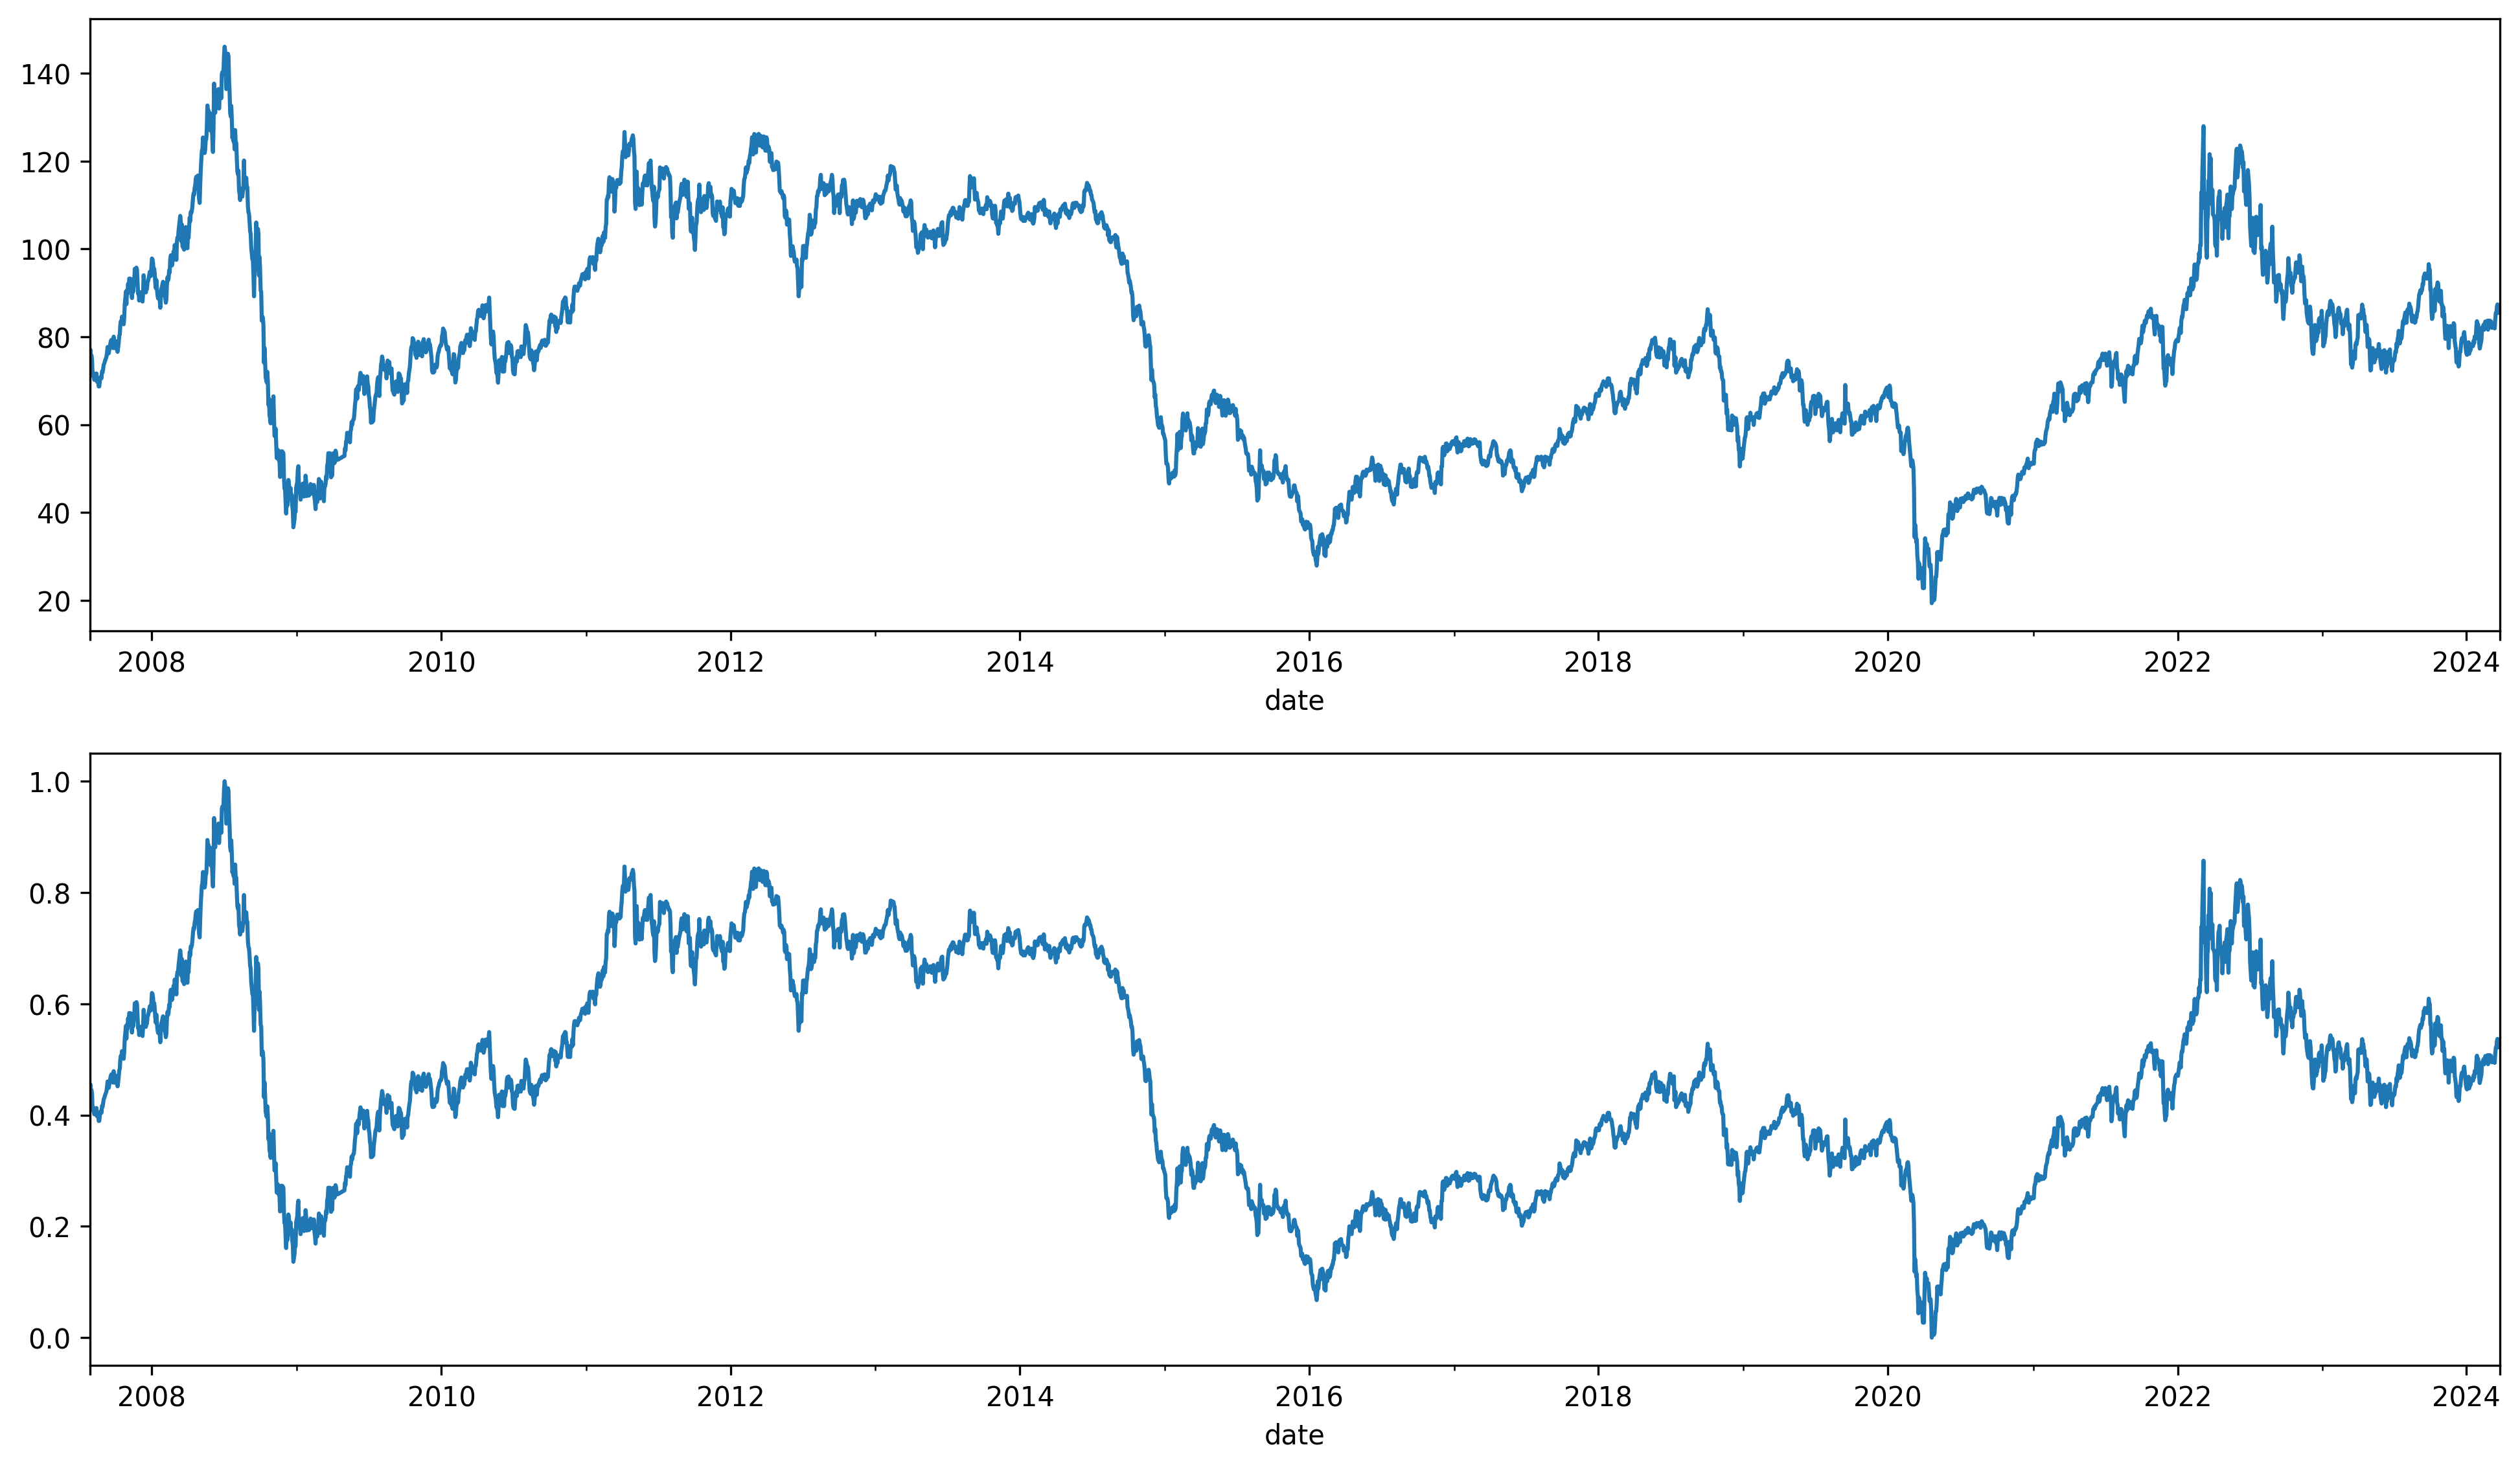

In [5]:
import matplotlib.pyplot as plt

# Comparing plots for scaled and normalized data (should look the same)
fig, axs = plt.subplots(2, 1, figsize=(16, 9))
brent_oil_close_df['Close value']['Original']['Scaled'].plot(ax=axs[0])
brent_oil_close_df['Close value']['Original']['Normalized'].plot(ax=axs[1])
plt.gcf().set_dpi(300)
plt.show()

In [6]:
class TimeSeriesHandler:
    def __init__(self):
        self.operations = []
    
    def _split(self, data: np.ndarray) -> dict[str, np.ndarray]:
        if not isinstance(data, np.ndarray):
            raise ValueError("Data must be a numpy array")
        if self.test_split is None:
            raise ValueError("Test split not set")
        split = int(len(data) * self.test_split)
        return {
            "train": data[:-split],
            "test": data[-split:]
        }
    
    def _sequence(
        self,
        data: np.ndarray | dict[str, np.ndarray]
    ) -> dict[str, np.ndarray]:
        if isinstance(data, dict):
            train_split = self._sequence(data["train"])
            test_split = self._sequence(data["test"])
            return {
                "x_train": train_split["x"],
                "y_train": train_split["y"],
                "x_test": test_split["x"],
                "y_test": test_split["y"]
            }
        if not isinstance(data, np.ndarray):
            raise ValueError("Data must be a numpy array")
        x = np.array([
            data[i : i + self.prev] for i in range(len(data) - self.sequence_size)
        ])
        y = np.array([
            data[i + self.prev : i + self.sequence_size] for i in range(len(data) - self.sequence_size)
        ])
        return {
            "x": x,
            "y": y
        }

    def prepare_split(self, test_split: float):
        self.test_split = test_split
        if self._sequence in self.operations:
            raise ValueError("Cannot split after sequence transformation")
        elif self._split in self.operations:
            raise ValueError("Cannot split after split transformation")
        self.test_split = test_split
        self.operations.append(self._split)
        return self

    def prepare_sequences(self, prev: int, future: int):
        if self._sequence in self.operations:
            raise ValueError("Cannot sequence after sequence transformation")
        self.prev = prev
        self.future = future
        self.sequence_size = prev + future
        self.operations.append(self._sequence)
        return self
    
    def get_transformed(self, data: np.ndarray):
        transformed = data
        for op in self.operations:
            transformed = op(transformed)
        return transformed

In [7]:
from sklearn.svm import SVR

handler = TimeSeriesHandler().prepare_split(0.2).prepare_sequences(10, 5)
prepared_data = handler.get_transformed(brent_oil_close_df['Close value']['Original']['Normalized'].to_numpy())
indexes_partition = handler.get_transformed(brent_oil_close_df.index.to_numpy())
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(prepared_data["x_train"], prepared_data["y_train"][:, 0])

SVR(C=10, epsilon=0.05, gamma=0.5)

Testando desempenho em predições unipasso

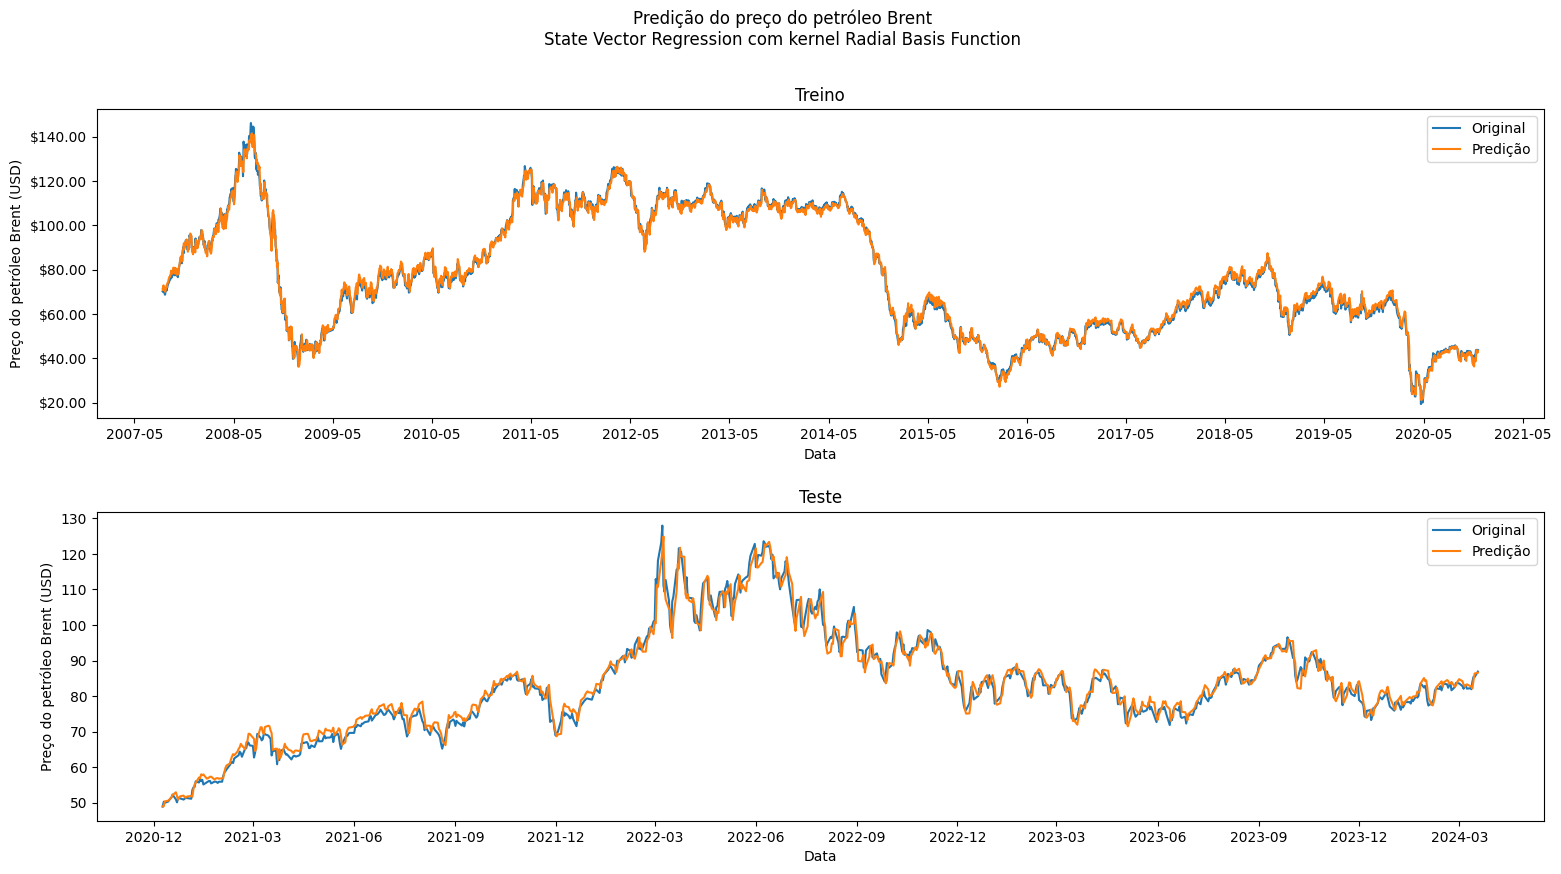

In [8]:
import matplotlib.dates as mdates

train_time_index = indexes_partition["y_train"][:, 0]
train_pred = scaler_.inverse_transform(model.predict(prepared_data["x_train"]))
test_pred = scaler_.inverse_transform(model.predict(prepared_data["x_test"]))

fig, ax = plt.subplots(2, 1, figsize=(16,9))

ax[0].plot(train_time_index, scaler_.inverse_transform(prepared_data["y_train"][:, 0]), label="Original")
ax[0].plot(train_time_index, train_pred, label="Predição")
ax[0].set_title("Treino")
ax[0].legend()
ax[0].set_xlabel("Data")
ax[0].set_ylabel("Preço do petróleo Brent (USD)")
ax[0].yaxis.set_major_formatter('${x:,.2f}')
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

test_time_index = indexes_partition["y_test"][:, 0]
ax[1].plot(test_time_index, scaler_.inverse_transform(prepared_data["y_test"][:, 0]), label="Original")
ax[1].plot(test_time_index, test_pred, label="Predição")
ax[1].set_title("Teste")
ax[1].legend()
ax[1].set_xlabel("Data")
ax[1].set_ylabel("Preço do petróleo Brent (USD)")
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.suptitle('Predição do preço do petróleo Brent\nState Vector Regression com kernel Radial Basis Function')
fig.tight_layout(pad=2.0)
plt.savefig("time_plot.png", dpi=300)

Parece bom. Vamos ver as estatísticas de erro para mais de um passo.

In [9]:
class MultiStepSVRPredictor:
    def __init__(self, model: SVR):
        self.model = model

    def predict(self, data: np.ndarray, future: int) -> np.ndarray:
        if not isinstance(data, np.ndarray):
            raise ValueError("Data must be a numpy array")
        if future <= 0:
            raise ValueError("Future must be greater than 0")
        shape = list(data.shape)
        shape[0] = shape[0] + future
        shape = tuple(shape)
        data_with_predictions = np.full(shape, np.nan)
        data_with_predictions[:data.size] = data
        for i in range(data.size, data.size + future):
            prediction = self.model.predict(data_with_predictions[i - data.size : i].reshape(1, -1))
            data_with_predictions[i] = prediction[0]
        return {
            "previous": data,
            "predicted": data_with_predictions[data.size:]
        }

multi_predictor = MultiStepSVRPredictor(model)
train_pred_multi = np.full_like(prepared_data["y_train"], np.nan)
test_pred_multi = np.full_like(prepared_data["y_test"], np.nan)
for i in range(len(prepared_data["x_train"])):
    train_pred_multi[i] = multi_predictor.predict(prepared_data["x_train"][i], 5)["predicted"]
for i in range(len(prepared_data["x_test"])):
    test_pred_multi[i] = multi_predictor.predict(prepared_data["x_test"][i], 5)["predicted"]

In [10]:
brent_oil_close_df.loc[train_time_index, ('Close value', 'Predicted', 'Normalized')] =\
    train_pred_multi[:, 0]
brent_oil_close_df.loc[test_time_index, ('Close value', 'Predicted', 'Normalized')] =\
    test_pred_multi[:, 0]

In [11]:
brent_oil_close_df.loc[:, ('Close value', 'Predicted', 'Scaled')] =\
    scaler_.inverse_transform(brent_oil_close_df['Close value']['Predicted']['Normalized'].to_numpy())
brent_oil_close_df[8:15]
brent_oil_close_df[-15:]

Close value                                 
              Original             Predicted           
                Scaled Normalized     Scaled Normalized
date                                                   
2024-03-05   82.040001   0.494753  83.198343   0.503892
2024-03-06   82.959999   0.502012  82.690415   0.499885
2024-03-07   82.959999   0.502012  83.047729   0.502704
2024-03-08   82.080002   0.495069  83.297101   0.504671
2024-03-11   82.209999   0.496095  82.794325   0.500705
2024-03-12   81.919998   0.493807  82.681946   0.499818
2024-03-13   84.029999   0.510454  82.142220   0.495560
2024-03-14   85.419998   0.521420  84.386939   0.513270
2024-03-15   85.339996   0.520789  86.342204   0.528696
2024-03-18   86.889999   0.533018  86.580876   0.530579
2024-03-19   87.379997   0.536884        NaN        NaN
2024-03-20   85.949997   0.525602        NaN        NaN
2024-03-21   85.779999   0.524260        NaN        NaN
2024-03-22   85.430000   0.521499        NaN        NaN
2024-03-25   86.730003   0.531755        NaN        NaN

In [12]:
# Erro por passo
train_pred_multi = scaler_.inverse_transform(train_pred_multi)
test_pred_multi = scaler_.inverse_transform(test_pred_multi)
train_mse = np.mean((
    train_pred_multi - scaler_.inverse_transform(prepared_data["y_train"])
) ** 2, axis=0)
test_mse = np.mean((
    test_pred_multi - scaler_.inverse_transform(prepared_data["y_test"])
) ** 2, axis=0)

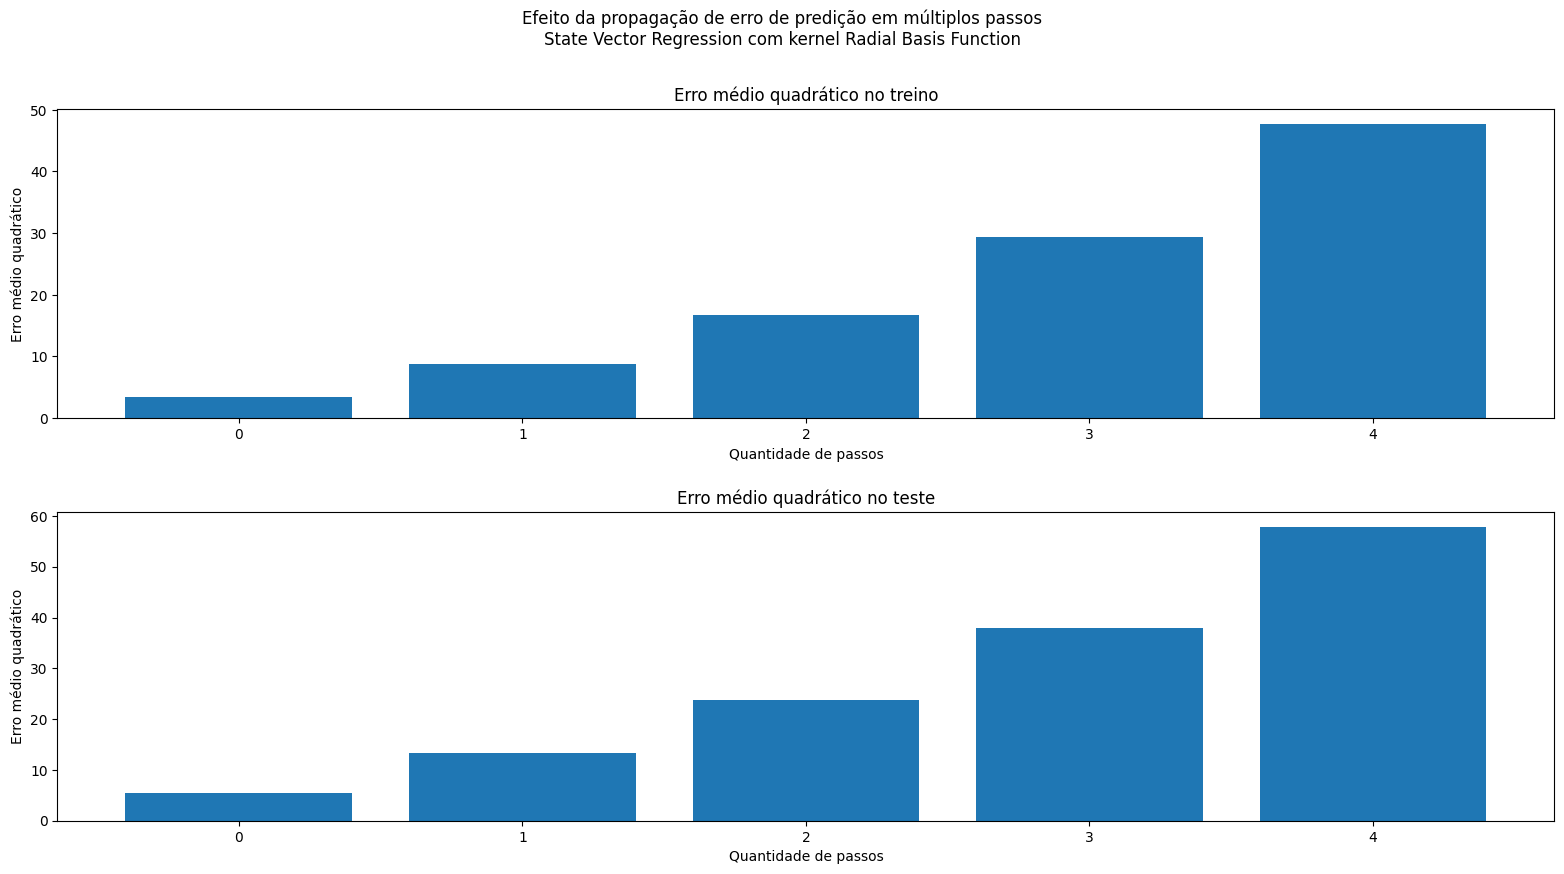

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16,9))

axs[0].bar(range(5), train_mse)
axs[0].set_title("Erro médio quadrático no treino")
axs[0].set_xlabel("Quantidade de passos")
axs[0].set_ylabel("Erro médio quadrático")

axs[1].bar(range(5), test_mse)
axs[1].set_title("Erro médio quadrático no teste")
axs[1].set_xlabel("Quantidade de passos")
axs[1].set_ylabel("Erro médio quadrático")

fig.suptitle('Efeito da propagação de erro de predição em múltiplos passos\nState Vector Regression com kernel Radial Basis Function')
fig.tight_layout(pad=2.0)
plt.savefig("multi_step_error.png", dpi=300)
plt.show()

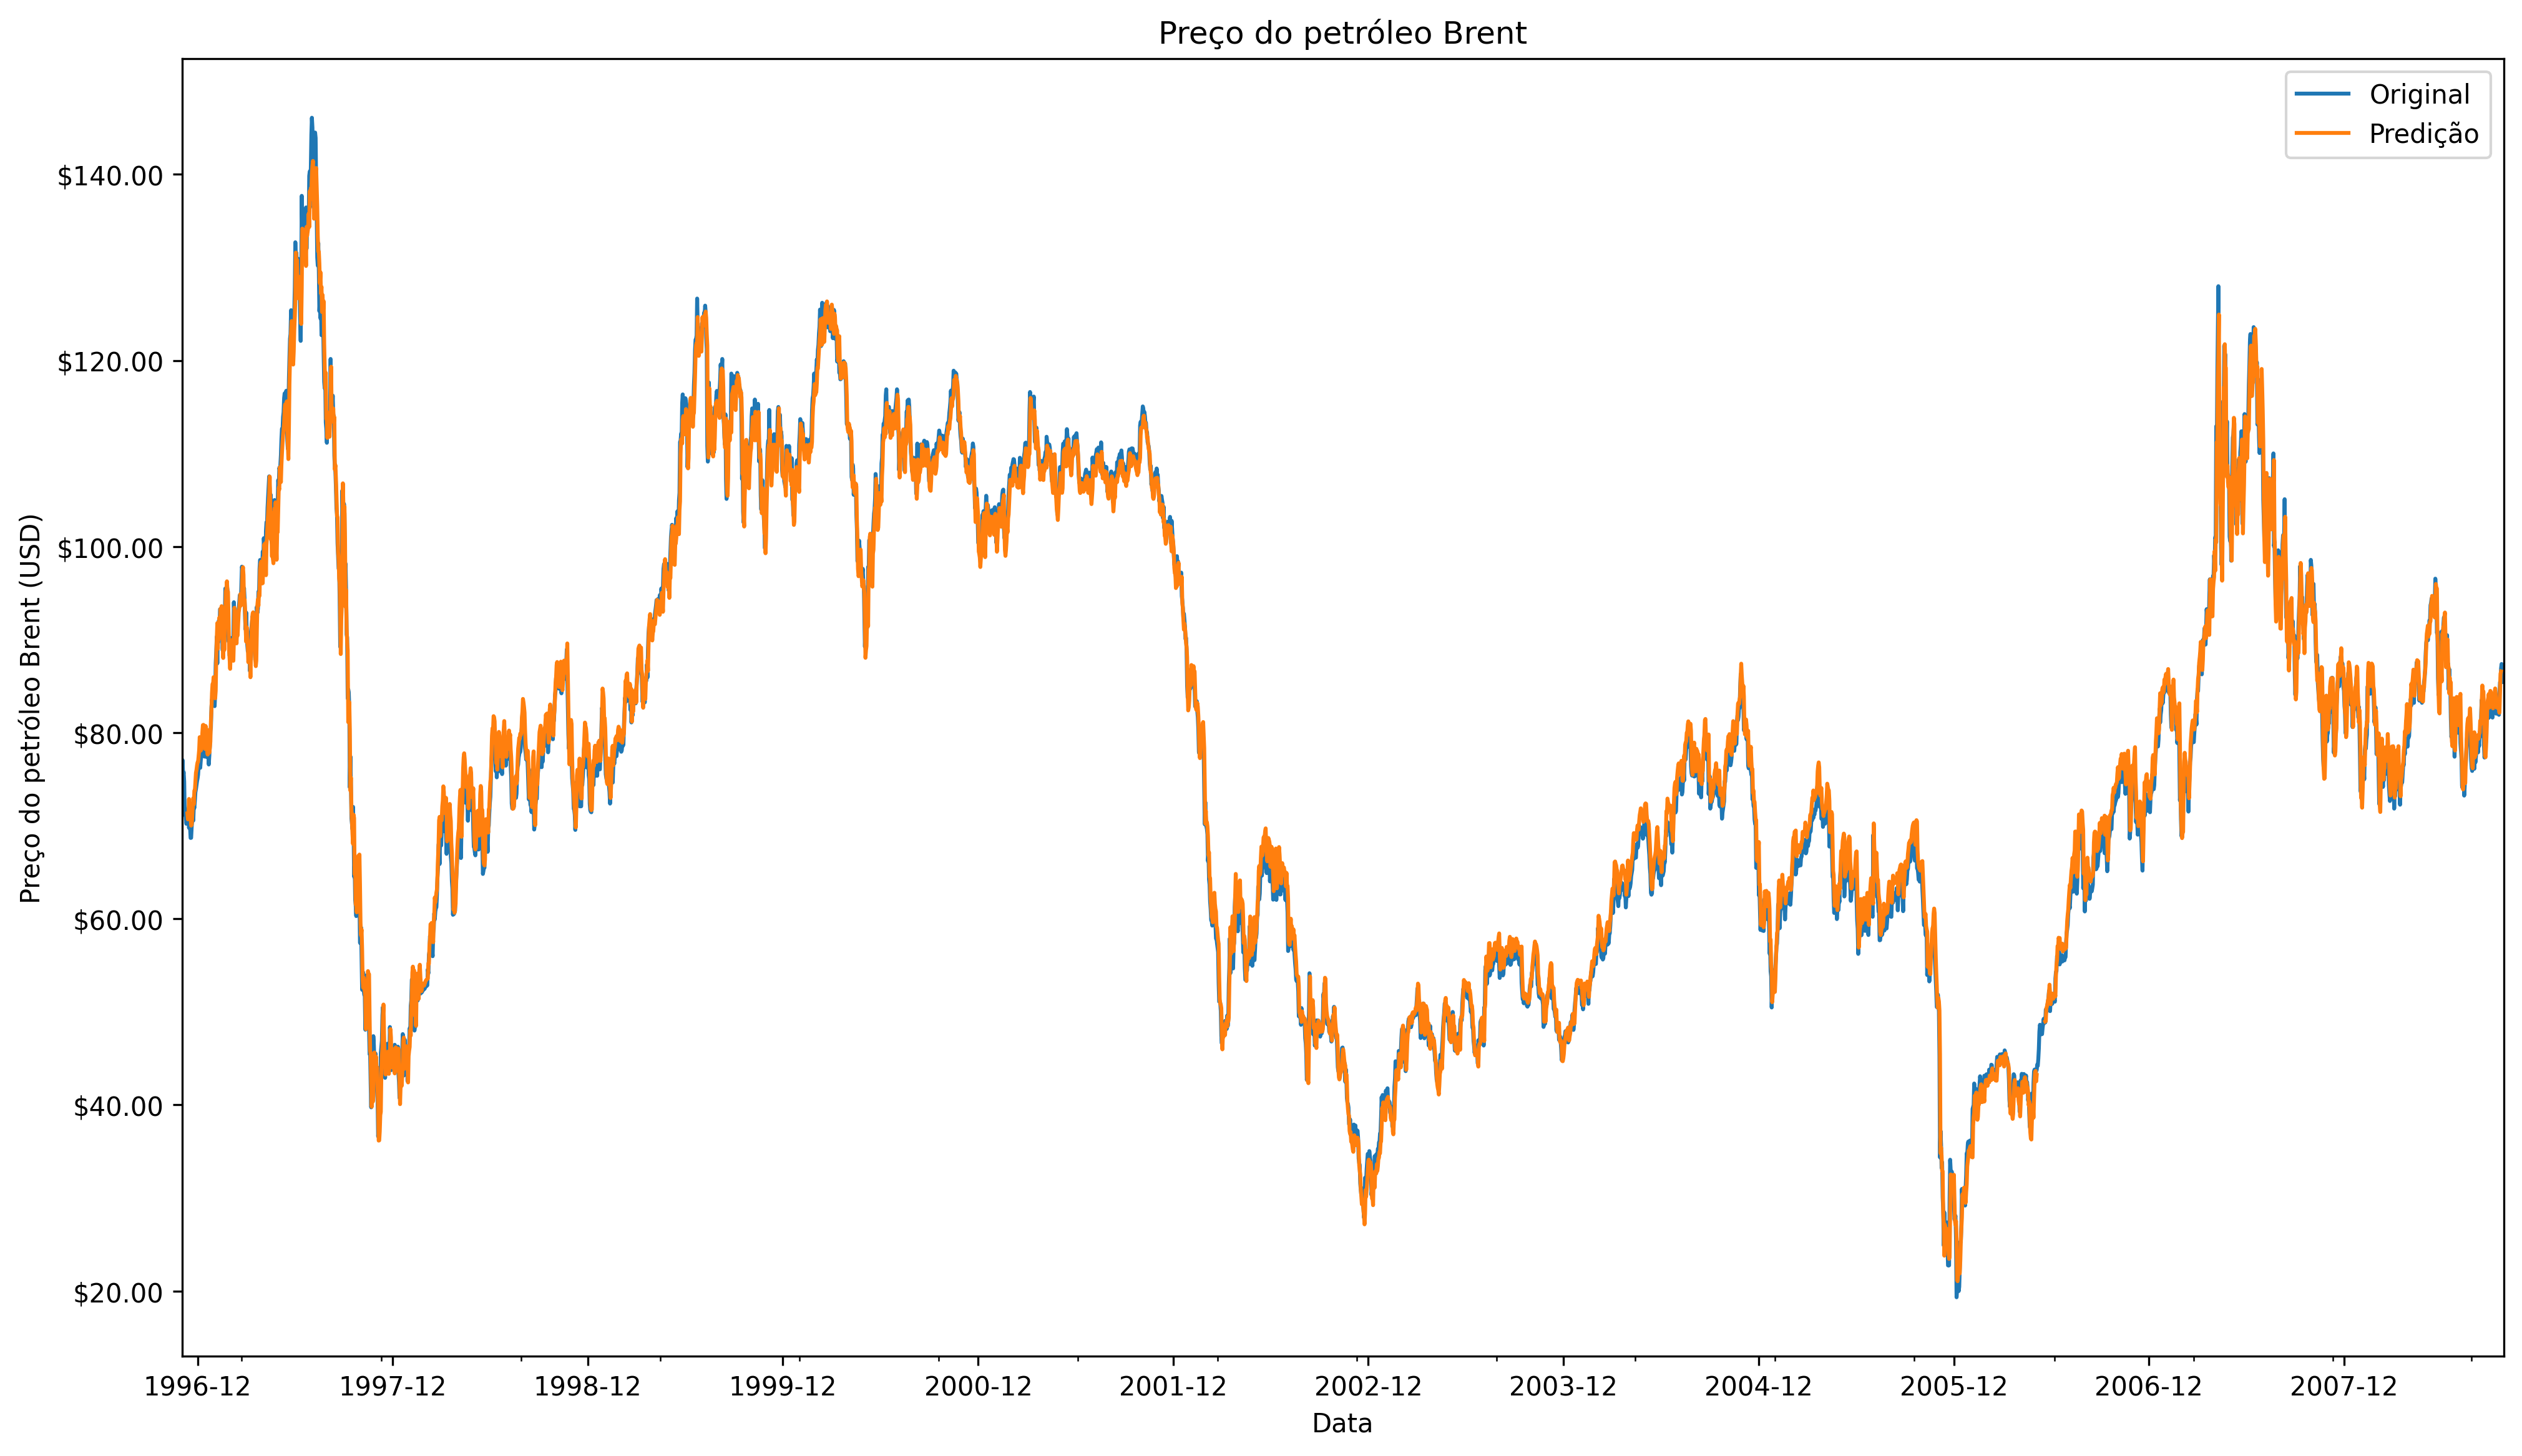

In [14]:
# Gráfico com a escala
fig, ax = plt.subplots(figsize=(16,9))
brent_oil_close_df['Close value']['Original']['Scaled'].plot(ax=ax, label="Original")
brent_oil_close_df['Close value']['Predicted']['Scaled'].plot(ax=ax, label="Predição")
ax.set_title("Preço do petróleo Brent")
ax.set_xlabel("Data")
ax.set_ylabel("Preço do petróleo Brent (USD)")
ax.yaxis.set_major_formatter('${x:,.2f}')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
plt.gcf().set_dpi(300)
plt.show()